### WineELO

Star ratings are everywhere we look these days. Whether it be Uber, Amazon or Google - these rating scales have become ubiquitous.

A lot has been said and written about the merit of star ratings. They suffer from a range of problems, including overrepresentation of extreme views in an average rating, different standards across users for what constitutes good/bad and anchoring effects of existing ratings. 

So is there an alternative? Well, maybe. In this analysis we are going to explore whether we can borrow from the game of chess to come up with a new type of wine rating: WineELO, a variation of the ELO score used to evaluate the relative strength of chess players. 

In [42]:
import pandas as pd
import numpy as np
import os
import json
import time
import datetime
from chessratings import uscf_elo
import wine_data_cleanup as wdc
from matplotlib import pyplot as plt

pd.set_option('mode.chained_assignment', None)

First off, we need a dataset to work with. Wine rating app Vivino has been collecting star ratings for wines from its users for years. We have scraped all the ~1 million wine reviews by the top 2,500 Vivino users in the Netherlands (see web_scraper.py for details).

The output files from our web scraper are JSONs. We will combine these JSONs into a single dataframe.

In [43]:
all_wine_reviews = []
for f in os.listdir('raw_data'):
    filename = 'raw_data/' + f
    with open(filename, 'r') as contents:
        user_wine_reviews = json.loads(contents.read())
        user_id = f.split('.')[0]
        scrape_date_unix = os.path.getmtime(filename)
        scrape_date = datetime.datetime.fromtimestamp(scrape_date_unix)
        for u in user_wine_reviews:
            u['reviewer'] = user_id
            u['scrape_date'] = scrape_date
            all_wine_reviews.append(u)

wine_review_df = pd.json_normalize(all_wine_reviews)
wine_review_df.head()

,wine_id,review_date,review_time_ago,vintage,rating,wine_name,producer,region_name,country_name,average_rating,nr_ratings,reviewer,scrape_date
0,159717279,"Thu, Apr 29th at 16:24:15 UTC",2 days ago,2019,3.5,Chianti,Sensi,Chianti,Italy,"3,3",279,30112979,2021-05-01 20:02:23.750630
1,157184020,"Wed, Apr 28th at 15:59:40 UTC",3 days ago,2018,3.0,La Chapelle de Pied Vaurias Côtes-du-Rhône,Vignerons de l'Enclave,Côtes-du-Rhône,France,"3,3",264,30112979,2021-05-01 20:02:23.750630
2,160175069,"Mon, Apr 26th at 16:21:29 UTC",5 days ago,2019,4.0,Valpolicella Ripasso Classico Superiore,Villa Mondi,Valpolicella Ripasso,Italy,"3,7",89,30112979,2021-05-01 20:02:23.750630
3,168019781,"Sun, Apr 25th at 15:56:30 UTC",6 days ago,2019,3.0,Vida Libre Blanco,Carlos Ruben,Vino de España,Spain,"0,0",2,30112979,2021-05-01 20:02:23.750630
4,163444783,"Fri, Apr 23rd at 15:53:49 UTC",8 days ago,2020,3.5,MV Malbec,Mendoza Vineyards,Mendoza,Argentina,"3,7",148,30112979,2021-05-01 20:02:23.750630


We can now use our raw datafile to create two tables: 

1. A table containing wine metadata that we can use to slice and dice our results later on
2. A table we can use to feed data into our ELO algorithm

In [44]:
# create a dataframe containing metadata about each wine in our dataset

wine_metadata = wine_review_df[['wine_id', 'vintage', 'wine_name', 'producer', 'region_name', 'country_name', 'nr_ratings']].drop_duplicates()
wine_metadata.set_index('wine_id', inplace=True)
wine_metadata.head()

,vintage,wine_name,producer,region_name,country_name,nr_ratings
wine_id,,,,,,
159717279,2019,Chianti,Sensi,Chianti,Italy,279
157184020,2018,La Chapelle de Pied Vaurias Côtes-du-Rhône,Vignerons de l'Enclave,Côtes-du-Rhône,France,264
160175069,2019,Valpolicella Ripasso Classico Superiore,Villa Mondi,Valpolicella Ripasso,Italy,89
168019781,2019,Vida Libre Blanco,Carlos Ruben,Vino de España,Spain,2
163444783,2020,MV Malbec,Mendoza Vineyards,Mendoza,Argentina,148


Now, we can proceed with our second table - we first need to do some cleanup before we can convert our wine ratings to ELO scores. 

We want a simplified table that contains one row per wine review, with only the necessary information about that review (the reviewer, review date and the rating out of 5).

In [45]:
wine_reviews_cleaned = wdc.clean_wine_reviews(wine_review_df).set_index('wine_id').reset_index()
wine_reviews_cleaned.drop_duplicates(inplace=True)
wine_reviews_cleaned.set_index('wine_id', inplace=True)

wine_reviews_cleaned.head()

,reviewer,rating,final_review_date
wine_id,,,
159717279,30112979,3.5,2021-04-29
157184020,30112979,3.0,2021-04-28
160175069,30112979,4.0,2021-04-26
168019781,30112979,3.0,2021-04-25
163444783,30112979,3.5,2021-04-23


Let's take a closer look at these reviews - can we learn anything about how these star ratings are distributed by reviewer?

<ipython-input-48-4a9332b58049>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


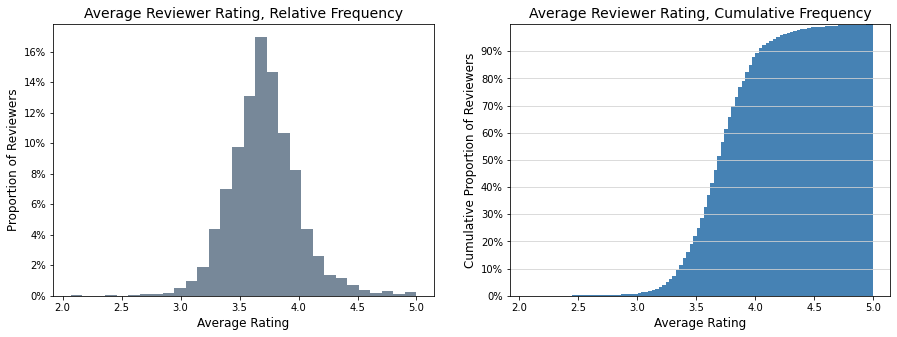

In [48]:
reviewer_distro = wine_reviews_cleaned.groupby('reviewer').agg({'rating': ['describe']})
plot_series = reviewer_distro[('rating', 'describe', 'mean')]

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(plot_series, weights=np.zeros_like(plot_series) + 1/plot_series.size, bins=30, color='lightslategray')
plt.title('Average Reviewer Rating, Relative Frequency', fontsize=14)
plt.ylabel('Proportion of Reviewers', fontsize=12)
plt.xlabel('Average Rating', fontsize=12)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 

plt.subplot(1, 2, 2)
plt.hist(plot_series, weights=np.zeros_like(plot_series) + 1/plot_series.size, bins=100, color='steelblue', cumulative=True)
plt.title('Average Reviewer Rating, Cumulative Frequency', fontsize=14)
plt.ylabel('Cumulative Proportion of Reviewers', fontsize=12)
plt.xlabel('Average Rating', fontsize=12)
plt.grid(color='lightgrey', linestyle='-', axis='y')
plt.ylim(0, 1)
plt.yticks(np.arange(0.0, 1.0, 0.1))
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 

plt.show()

This view of the data confirms some of the shortcomings of a system based on average ratings - most importantly that reviewers apply the star rating scale differently. Our dataset supports this, despite consisting of a group of reviewers that is geographically (and likely culturally) relatively homogenous. The 10% most critical reviewers award wines with less than 3.3/5 points, on average. The 10% most generous reviewers give upwards of 4/5 points on average. This spread is likely to be worse when looking at average review scores from users that are less homogenous (e.g. across different countries). 

While it is possible that more critical reviewers are simply drinking worse wines, this is unlikely to explain for the entirety of the variance here. It stands to reason that some people simply give lower or higher ratings to wines, on average. This has a bearing on average wine ratings also. If a wine has been rated by generous individuals, it will have a higher score than if it has been rated by more critical users.

### From a star rating to WineELO

We're almost ready to compute our ELO scores. We still, however, need to introduce a few key concepts and do a couple more data transformations. 

ELO scores are normally used to model skill levels in zero-sum games, most famously in chess. The difference in ratings between chess players serves as an indicator for who is more likely to win a match. Each match has one of three possible outcomes: win, draw or loss. Both players' scores are adjusted after a match based on the actual vs. expected outcome. Players will often compete in tournaments that consist of several matches. Here, score updates are typically done after a tournament has been conducted rather than after each individual match. 

We can circumvent many of the problems that plague star rating systems by framing a *reviewer's individual ratings on a given day* as a tournament of zero-sum matches. For this purpose, let us propose the following definitions:

- **Player**: a specific wine from a specific vintage
- **Match**: a head-to-head zero-sum comparison of two wines reviewed on a specific day by a specific individual
- **Tournament**: the collection of head-to-head matches by a specific individual on a specific day

The structure above relies on the basic assumption that we can trust a person to be ordinally consistent in the way they rank wines on a given day. If they give one wine 4 stars and another wine 5 on a given day, we can deduce that the 5-star wine was better than the 4-star one. 

#### Example

A hypothetical example to illustrate:

Reviewer John reviewed 3 different wines on April 29th, 2021: wine A, wine B and wine C.

- Wine A: 5 stars
- Wine B: 4 stars
- Wine C: 4 stars

As a head-to-head zero sum game these results would look as follows:

- Wine A vs. Wine B: Wine A wins, Wine B loses
- Wine A vs. Wine C: Wine A wins, Wine C loses
- Wine B vs. Wine C: Draw

These three head-to-head **matches** can be grouped together in a **tournament**. We will run these tournaments chronologically. A wine (**player**) that has not participated in a tournament yet will receive a newly initialized ELO score, while a wine that has participated in tournaments in the past will enter a new tournament with its most recent ELO score. 

As we run each tournament, we will store information about each in a lookup table. This will allow us to study how wine ELO scores have evolved over time.


#### Quick note on ELO scores

Before we dive in, it is worth pointing out which implementation of the ELO score algorithm we are using. We are using the most recent (2021) rules used by the US Chess Federation (USCF) as captured in the chessratings package. 

Alright, enough explanation! Let's run the tournaments.

In [49]:
# score lookup table will store information about player performance that we need to initialize ratings as we run tournaments.
score_lookup_table_columns = ['wine_id', 'tournament_date', 'tournament_number', 'elo_rating', 'nr_games_played', 'nr_wins', 'nr_losses', 'reviewer']
score_lookup_table = pd.DataFrame(columns=score_lookup_table_columns)
all_results = wdc.run_tournaments(wine_reviews_cleaned, score_lookup_table)
all_results.to_csv('all_results.csv')
all_results.head()

,wine_id,tournament_date,tournament_number,elo_rating,nr_games_played,nr_wins,nr_losses,reviewer,nr_draws
0,1425299,2012-08-11,1,1300.0,2,0,0,259949,2.0
1,1541020,2012-08-11,1,1300.0,2,0,0,259949,2.0
2,1425289,2012-08-11,1,1300.0,2,0,0,259949,2.0
0,1442185,2012-08-25,1,1400.0,3,2,1,277053,0.0
1,1384827,2012-08-25,1,1050.0,3,0,2,277053,1.0


To better manage some of the volatility we may see in ELO scores, we will additionally compute a moving average ELO score, with a trailing window of 5 tournaments. This will allow us to smooth out the effect of individual tournaments skewing the score for any one wine, while preserving the ability to have wine scores trend up or down over time. 

This moving average elo is our WineELO score. 

In [310]:
all_results['wineELO'] = all_results.groupby('wine_id')['elo_rating'].transform(lambda x: x.rolling(5, 1).mean())

Now that we have our WineELO scores over time, we can start to explore the results. 

In [318]:
results_grouped = all_results.groupby('wine_id').agg({'tournament_date': 'max', 'nr_games_played': 'sum', 'nr_wins': 'sum', 'nr_draws': 'sum', 'nr_losses': 'sum', 'tournament_number': 'max'}).reset_index()
results_grouped = pd.merge(results_grouped, all_results[['wine_id', 'tournament_date', 'elo_rating', 'wineELO']], how='left', on=['wine_id', 'tournament_date']).drop_duplicates(subset=['wine_id'])

results_grouped = pd.merge(results_grouped, wine_metadata, left_on='wine_id', right_index=True).drop_duplicates(subset=['wine_id'])
results_grouped = results_grouped[['wine_id', 'vintage', 'tournament_date', 'elo_rating', 'wineELO', 'tournament_number', 'nr_games_played', 'wine_name', 'producer', 'region_name', 'country_name']]

results_grouped.sort_values(by=['wineELO'], ascending=False).head(5)

,wine_id,vintage,tournament_date,elo_rating,wineELO,tournament_number,nr_games_played,wine_name,producer,region_name,country_name
151744,165246948,1989,2020-12-24,2700.0,2700.0,1,2,Muscat de Beaumes-de-Venise Doux Naturel,Paul Jaboulet Aîné,Muscat de Beaumes de Venise,France
177025,2264965,2009,2020-03-20,2700.0,2700.0,1,17,Frühlingsplätzchen Riesling GG,Emrich-Schönleber,Nahe,Germany
139992,161888404,2015,2020-04-12,2700.0,2700.0,1,3,Gallus Burgum Riesling Sekt Brut,Heidhof,Mosel,Germany
106480,157344820,2016,2020-11-21,2700.0,2700.0,1,6,No. 5 Edition Johannis Kreuz Holsfass Riesling...,Sankt Annaberg,Pfalz,Germany
81056,153438063,2016,2017-08-18,2700.0,2700.0,1,2,Vieilles Vignes Bourgogne Hautes-Côtes de Beaune,Quentin Jeannot,Bourgogne Hautes-Côtes de Beaune,France


It is apparent from our results that all of the best-performing wines listed above have only participated in a single tournament. Can we really trust that the best wines in our dataset have only competed in a handful of tournaments and maches?

The USCF can help here with a definition of what constitutes an 'established' rating: at least 25 matches. We will layer on top of this a minimum number of tournaments that we will require eligible wines to have competed in, to reduce the potential impact of a single user rating a wine very highly. 

In [312]:
results_grouped_bounded = results_grouped.loc[(results_grouped['tournament_number'] >= 10) & (results_grouped['nr_games_played'] >= 25)]
results_grouped_bounded.sort_values(by=['wineELO'], ascending=False).head(10)

,wine_id,vintage,tournament_date,elo_rating,wineELO,tournament_number,nr_games_played,wine_name,producer,region_name,country_name
71727,152394404,2017,2021-03-27,2506.563862,2512.726519,22,180,Reserve Chenin Blanc,DeMorgenzon,Stellenbosch,South Africa
98553,156567925,2018,2021-04-09,2133.251400,2220.681122,10,57,Dão Reserva Branco,Cabriz,Dão,Portugal
165041,1934046,2011,2020-10-13,1940.599230,1952.337064,10,263,Campo del Drago Brunello di Montalcino,Castiglion del Bosco,Toscana,Italy
17107,1282334,2011,2021-04-10,1893.663354,1918.450114,14,75,Sassicaia,Tenuta San Guido,Bolgheri Sassicaia,Italy
159558,1787087,2005,2020-12-29,1918.165285,1903.667386,12,77,Gran Reserva 890,La Rioja Alta,Rioja,Spain
150654,164942595,N.V.,2021-04-27,1874.935135,1895.358112,150,1441,Blanc de Blancs Brut Champagne,Ruinart,Champagne,France
171965,2123459,2010,2020-08-24,1871.143777,1886.924236,11,58,Clos du Marquis Saint-Julien,Château Léoville Las Cases,Saint-Julien,France
169229,2052116,2011,2020-04-27,1830.456115,1882.988310,10,251,Numanthia,Bodega Numanthia,Toro,Spain
188997,2695636,2012,2019-03-12,1849.289268,1878.813009,11,193,Cosecha,Hacienda Monasterio,Ribera del Duero,Spain
44955,145787275,2015,2019-09-08,1898.812646,1874.556043,10,49,Fleurie,Yvon Métras,Fleurie,France


We have a winner! The 2017 Reserve Chenin Blanc by DeMorgenzon in Stellenbosch, South Africa. This wine has participated in 22 valid tournaments and has competed against a total of 180 other wines. Its WineELO is currently 2513, putting it well above the other wines in our dataset. 

Let's take a look at how WineELO compares to the star ratings that this wine has received. 


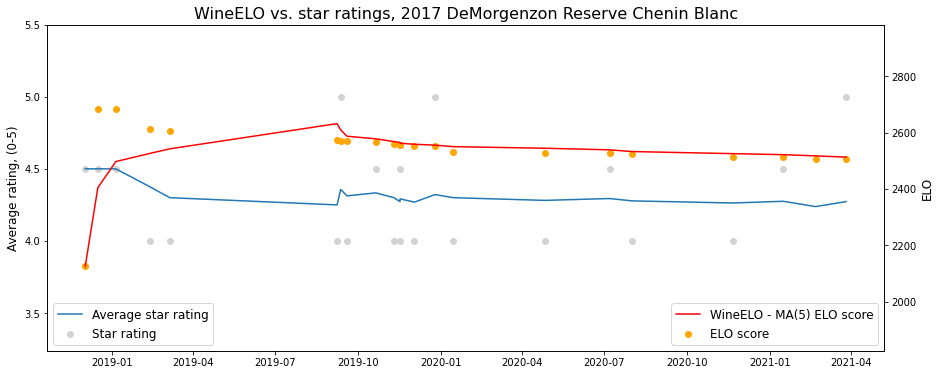

In [313]:
def plot_single_wine(wine_id, wine_name):
    one_wine_results = all_results.loc[all_results['wine_id'] == wine_id]

    reviews_and_scores = pd.merge(one_wine_results, wine_reviews_cleaned, left_on=['reviewer', 'wine_id', 'tournament_date'], right_on=['reviewer', 'wine_id', 'final_review_date'], how='left').drop_duplicates(subset='tournament_number')
    reviews_and_scores['rating_cumsum'] = reviews_and_scores['rating'].cumsum()
    reviews_and_scores['ma_rating'] = reviews_and_scores['rating_cumsum']/reviews_and_scores['tournament_number']

    fig, ax = plt.subplots(figsize=(15,6))
    ax.plot(reviews_and_scores['tournament_date'], reviews_and_scores['ma_rating'], label='Average star rating')
    min_y_rating = min(reviews_and_scores['ma_rating']) - 1
    max_y_rating = max(reviews_and_scores['ma_rating']) + 1
    ax.set_ylim([min_y_rating, max_y_rating])
    ax.set_ylabel('Average rating, (0-5)', fontsize=12)
    ax.scatter(reviews_and_scores['tournament_date'], reviews_and_scores['rating'], color='lightgrey', label='Star rating')
    ax.legend(loc='lower left', fontsize=12)

    ax2 = ax.twinx()
    ax2.plot(reviews_and_scores['tournament_date'], reviews_and_scores['wineELO'], color='r', label='WineELO - MA(5) ELO score')
    ax2.scatter(reviews_and_scores['tournament_date'], reviews_and_scores['elo_rating'], color='orange', label='ELO score')
    ax2.set_ylabel('ELO', fontsize=12)
    min_y_elo = min(reviews_and_scores['elo_rating']) - 300
    max_y_elo = max(reviews_and_scores['elo_rating']) + 300
    ax2.set_ylim([min_y_elo, max_y_elo])

    title_text = 'WineELO vs. star ratings, ' + wine_name
    plt.title(title_text, fontsize=16)

    plt.legend(loc='lower right', fontsize=12)

    plt.show()

plot_single_wine('152394404', '2017 DeMorgenzon Reserve Chenin Blanc')

This plot reveals that Vivino users consistently attributed scores of 4+ stars to this wine, producing an average rating of around 4.3.

Its ELO scores have been pretty consistent, hovering around the 2500-2600 range. There has been a moderate decay over time, after a peak was reached towards the end of 2019. 

The MA ELO can tell us how well (or poorly!) a wine is aging. The number of data points for our 2017 Chenin are likely insufficient to draw such conclusions, but let's take a look at a different wine from the dataset - a 2015 Rioja with 64 tournaments (303 games) under its belt:

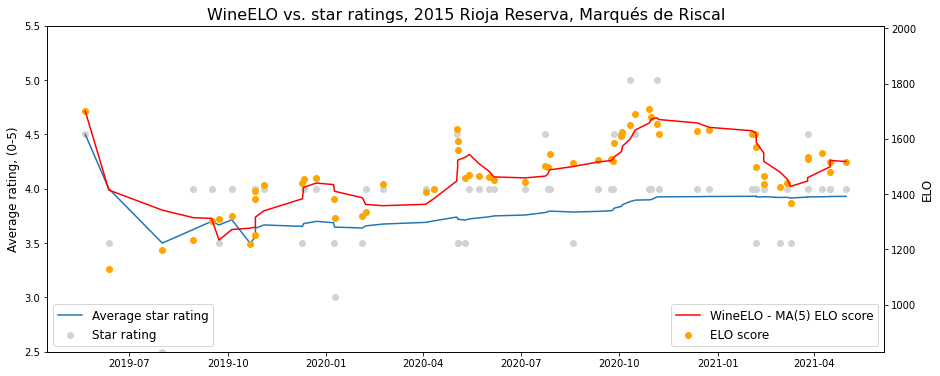

In [314]:
plot_single_wine('14201617', '2015 Rioja Reserva, Marqués de Riscal')

This Rioja's WineELO score seems to have improved quite steadily over the course of 2019 and 2020, before peaking towards the end of 2020. We can see a light dropoff in the months since. 

While we won't get into the statistical significance of this specific trend, it is worth noting the ability of WineELO score to highlight how the quality of a wine is changing over time. A simple average rating over the full lifetime of a wine cannot convey this information. 

Let's probe a little further on the differences between WineELO and the average 5-star rating by looking at all of the wines in our dataset: 

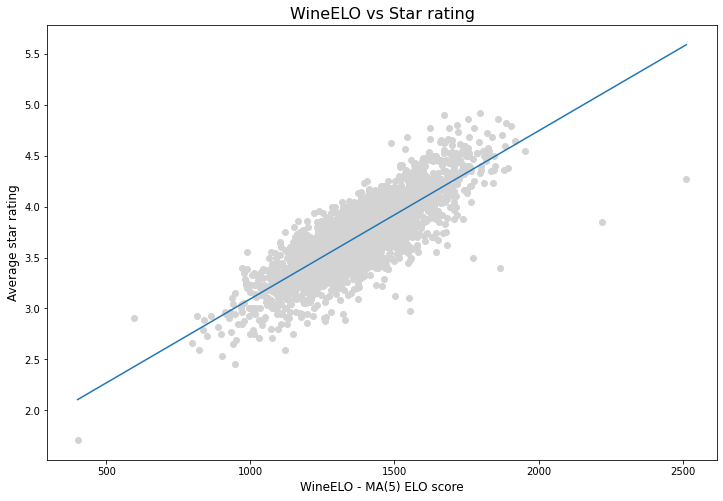

In [315]:
reviews_and_scores = pd.merge(all_results, wine_reviews_cleaned, left_on=['reviewer', 'wine_id', 'tournament_date'], right_on=['reviewer', 'wine_id', 'final_review_date']).drop_duplicates(subset=['wine_id', 'tournament_number'])
average_ratings = reviews_and_scores.groupby('wine_id')['rating'].mean().reset_index()
elo_vs_rating = pd.merge(average_ratings, results_grouped_bounded, on='wine_id')

x = elo_vs_rating['wineELO']
y = elo_vs_rating['rating']
plt.figure(figsize=(12, 8))
plt.scatter(x, y, color='lightgrey')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.title('WineELO vs Star rating', fontsize=16)
plt.xlabel('WineELO - MA(5) ELO score', fontsize=12)
plt.ylabel('Average star rating', fontsize=12)
plt.show()

We can see that there is (as expected!) a strong positive correlation between the average star rating and our WineELO. Wines with higher 5-star ratings generally have higher WineELO scores.

The deviations from this correlation are more interesting. We can see that wines with an average rating of 3.5 stars can have WineELO scores as low as 1000 or as high as 1700. Such wines may be improving in terms of their development (age), or may have been disproportionately been rated by more critical Vivino users. These wines may be underserved by simple average star ratings, which can conceal their quality relative to other wines on the platform.

We can use a line of best fit (blue line in the plot above) to indicate which wines are **outperforming** their average star rating. Wines to the right of this line have a higher WineELO score than their average 5-point rating might suggest - and may therefore deserve a bit more love. 



### Concluding Thoughts

So where does that leave us? Do we start a boycot against star ratings? Well - it's not that simple. 

Star rating systems are easy to understand. The WineELO score will be much less intuitive to the average user. It also has shortcomings that the 5-point rating scale does not have. Importantly, WineELO does not treat a 1 vs 5 star rating any differently than a 3 vs 3.5 star rating. The magnitude of preferences is lost in favor of a scheme that is zero-sum and more simplistic. 

Still, WineELO provides value in ways that an average 5-star rating cannot. The above is an exploratory exercise to show the potential of this metric, but only starts to lift the tip of the proverbial veil. The sample size used (wine reviews by top 2500 Vivino users in the Netherlands) is very small. The definition of what constitutes a valid tournament (wines rated on the same day by the same user) is also very constrictive and could be relaxed to allow for a larger number of head-to-head comparisons between wines. With more data and by finetuning some of the underlying assumptions, the WineELO ratings will become more robust and reliable. 

So how about this: let's use WineELO *in addition* to the average star rating. And discover some hidden gems such as the DeMorgenzon Reserve Chenin Blanc in the process! 